In [2]:
import os
import glob
import yaml
import shutil
from IPython.display import clear_output

import wandb
from ultralytics import YOLO

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [39]:
ROOT = ''
IMAGES_ROOT = 'datasets/images'
LABELS_ROOT = 'datasets/labels'
PREDICTIONS_ROOT = 'working/predictions'
RAW_DATA_ROOT = 'ICDAR2021'

RANDOM_STATE = 42
IMAGE_SIZE = (2048, 1447)
INPUT_SIZE = 1024
N_EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 8
CACHE_DATA = True
DEVICES = 'mps'

In [6]:
a = np.array(sorted(map(lambda x: x[:-4], os.listdir(os.path.join(RAW_DATA_ROOT, 'images', 'train')))))
b = np.array(sorted(map(lambda x: x[:-4], os.listdir(os.path.join(RAW_DATA_ROOT, 'labels', 'train')))))

(a == b).all()

True

In [32]:
image = cv2.imread("ICDAR2021/images/train/0304110-page14.jpg")
image.shape

(2048, 1447, 3)

In [28]:
!rm -rf 'datasets'

!mkdir 'datasets'
!mkdir 'datasets/images'
!mkdir 'datasets/labels'

!mkdir 'datasets/images/train'
!mkdir 'datasets/images/test'
!mkdir 'datasets/images/validation'

!mkdir 'datasets/labels/train'
!mkdir 'datasets/labels/test'
!mkdir 'datasets/labels/validation'

In [29]:
for subset in ['train', 'test', 'validation']:
    # Retrieving all images and label for each subset of the data
    images = sorted(glob.glob(os.path.join(RAW_DATA_ROOT, 'images', subset, '*.jpg')))
    labels = sorted(glob.glob(os.path.join(RAW_DATA_ROOT, 'labels', subset, '*.txt')))
    
    for image, label in tqdm(zip(images, labels), total=len(images), desc=f'Copying {subset} data'):
        # Image copying
        shutil.copy(image, os.path.join(IMAGES_ROOT, subset))
        
        # Label copying (have to process bounding box coordinates 
        # since they are not yet normalized)
        label_name = label.split("/")[-1]
        with open(label, 'r') as lf:
            label_lines = map(lambda l: l.split(), lf.readlines())
            
        for line in label_lines:
            line = np.array(line, dtype=np.float16)
            
            x_min, y_min = line[[1, 2]]
            x_max, y_max = line[[3, 4]]
            
            x_center = str((x_min + x_max) / (2 * IMAGE_SIZE[1]))
            y_center = str((y_min + y_max) / (2 * IMAGE_SIZE[0]))
            width = str((x_max - x_min) / IMAGE_SIZE[1])
            height = str((y_max - y_min) / IMAGE_SIZE[0])
                
            with open(os.path.join(LABELS_ROOT, subset, label_name), "a+") as lf:
                lf.write(str(int(line[0])) + " ")
                lf.write(" ".join([x_center, y_center, width, height]))
                lf.write("\n")

Copying train data:   0%|          | 0/5171 [00:00<?, ?it/s]

Copying test data:   0%|          | 0/2144 [00:00<?, ?it/s]

Copying validation data:   0%|          | 0/957 [00:00<?, ?it/s]

In [30]:
with (
    open("datasets/labels/train/0304110-page14.txt", "r") as lf1,
    open("ICDAR2021/labels/train/0304110-page14.txt", "r") as lf2
):
    label1 = list(map(lambda x: x.strip().split(" "), lf1.readlines()))
    label2 = list(map(lambda x: x.strip().split("\t"), lf2.readlines()))

label1 = np.array(label1, dtype=np.float16)
label2 = np.array(label2, dtype=np.float16)

label1[:, [1, 3]] *= IMAGE_SIZE[1]
label1[:, [2, 4]] *= IMAGE_SIZE[0]

label1[:, 1] -= label1[:, 3] // 2
label1[:, 2] -= label1[:, 4] // 2

label1[:, 3] += label1[:, 1]
label1[:, 4] += label1[:, 2]

label1 = label1.astype(int)

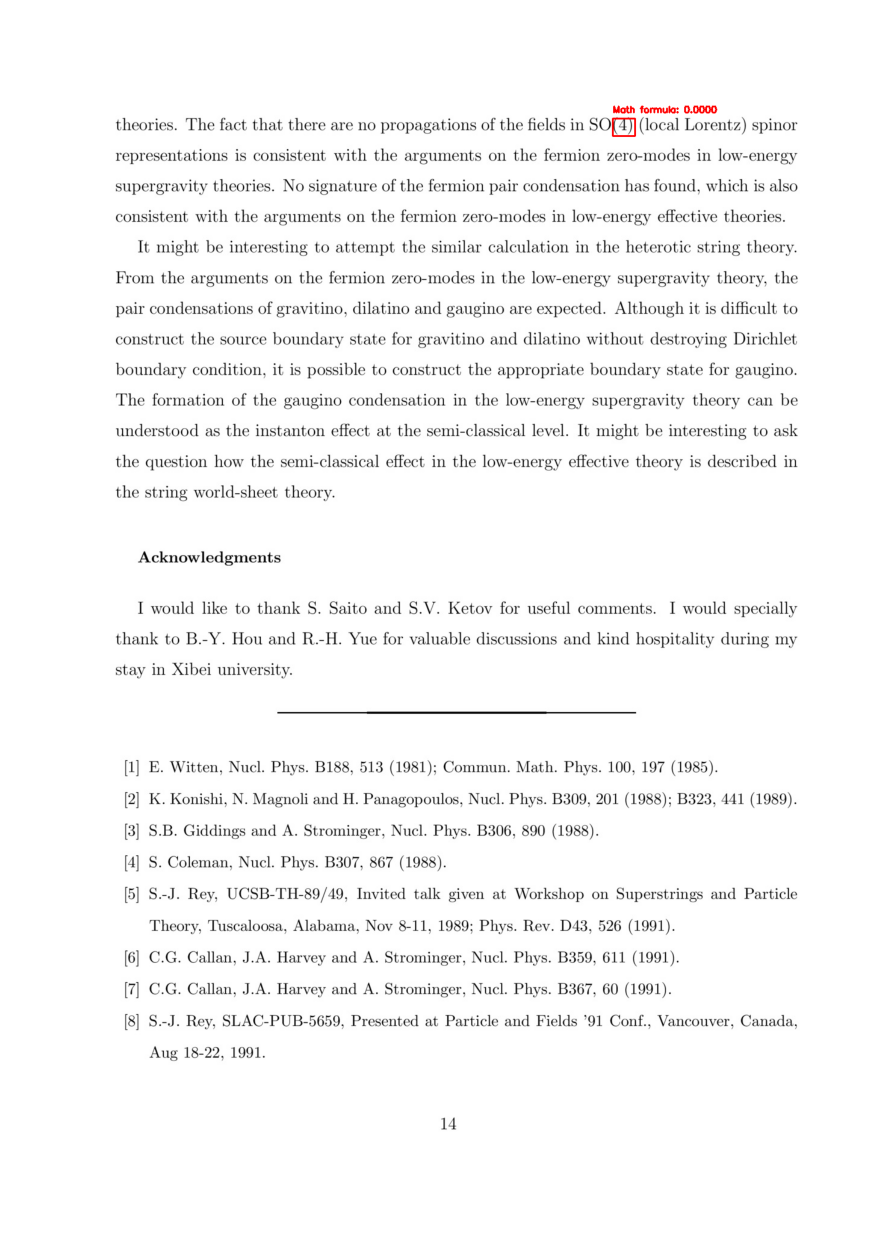

In [33]:
plt.figure(figsize=(16, 16))

plot_image_with_bbox(
    image=image, 
    bboxes=label1[:, 1:],
    scores=label1[:, 0],
    color=(255, 0, 0),
    ax=plt
)

In [40]:
data_config = {
    'path': ROOT,
    'train': 'images/train',
    'val': 'images/validation',
    'nc': 1,
    'names': {0: "math formula"}
}
             
with open('data.yaml', 'w+') as outfile:
    yaml.dump(data_config, outfile, default_flow_style=False)

In [41]:
wandb.login(key="4963260f329cc0b9c0d80113140aa7f45f8e1e2d")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/mishashkarubski/.netrc


True

In [42]:
model = YOLO('yolov8m.pt')

In [43]:
model.train(
    data="data.yaml", 
    epochs=N_EPOCHS, 
    patience=PATIENCE, 
    imgsz=INPUT_SIZE,
    batch=BATCH_SIZE, 
    seed=RANDOM_STATE,
    cache=CACHE_DATA,
    device=DEVICES,
    project='Math-formula-detection',
)

Ultralytics YOLOv8.0.180 🚀 Python-3.11.4 torch-2.0.1 MPS (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, patience=5, batch=8, imgsz=1024, save=True, save_period=-1, cache=True, device=mps, workers=8, project=Math-formula-detection, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False

Freezing layer 'model.22.dfl.conv.weight'
train: Scanning /Users/mishashkarubski/PycharmProjects/math-formula-detection/datasets/labels/train... 4649 images, 522 backgrounds, 0 corrupt: 100%|██████████| 5171/5171 [00:00<00:00, 5723.37it/s]
train: New cache created: /Users/mishashkarubski/PycharmProjects/math-formula-detection/datasets/labels/train.cache
train: Caching images (10.7GB True): 100%|██████████| 5171/5171 [00:10<00:00, 508.85it/s]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /Users/mishashkarubski/PycharmProjects/math-formula-detection/datasets/labels/validation... 856 images, 101 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<00:00, 5681.91it/s]
val: New cache created: /Users/mishashkarubski/PycharmProjects/math-formula-detection/datasets/labels/validation.cache
val: Caching images (2.0GB True): 100%|██████████| 957/957 [00:02<00:00, 46

RuntimeError: MPS backend out of memory (MPS allocated: 7.93 GB, other allocations: 1.15 GB, max allowed: 9.07 GB). Tried to allocate 9.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [33]:
wandb.finish()

lr/pg0,▁▅████▇▇▇▇▆▆▆▆▆▅▅▅
lr/pg1,▁▅████▇▇▇▇▆▆▆▆▆▅▅▅
lr/pg2,▁▅████▇▇▇▇▆▆▆▆▆▅▅▅
metrics/mAP50(B),▅▆▄▆▇█▁▇▆████▇████
metrics/mAP50-95(B),▄▅▂▅▆▇▁▇▅▇▇██▆▇▇██
metrics/precision(B),▄▅▃▆▇█▁▇▆████▇▇███
metrics/recall(B),▃▅▂▆▇▇▁▇▆▇███▆▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁


In [ ]:
best_weights = "/kaggle/working/Math-formula-detection/train/weights/best.pt"
best_model = YOLO(best_weights) 
metrics = best_model.val() 

In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

In [ ]:
with torch.no_grad():
    predictions = best_model.predict(
        source="/kaggle/input/math-formula-detection/ICDAR2021/images/test",
        conf=0.50,
        iou=0.75,
        stream=True
    )

In [ ]:
!rm -rf "/kaggle/working/predictions"
!mkdir "/kaggle/working/predictions"

In [ ]:
test_images = []

for prediction in predictions:
    if len(prediction.boxes.xyxy):
        name = prediction.path.split("/")[-1].split(".")[0]
        boxes = prediction.boxes.xyxy.cpu().numpy()
        scores = prediction.boxes.conf.cpu().numpy()
        
        test_images += [name]
        label_path = os.path.join(PREDICTIONS_ROOT, name + ".txt")
        
        with open(label_path, "w+") as f:
            for score, box in zip(scores, boxes):
                text = f"{score:0.4f} {' '.join(box.astype(str))}"
                f.write(text)
                f.write("\n")

In [14]:
def plot_image_with_bbox(image, bboxes, scores, color, ax):
    bboxes = bboxes.astype(int)
    image = image.copy()
    
    for i, bbox in enumerate(bboxes):
        score = f"Math formula: {scores[i]:.4f}"
        text_y = bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 10
        
        cv2.rectangle(
            img=image,
            pt1=(bbox[0], bbox[1]), 
            pt2=(bbox[2], bbox[3]), 
            color=color, thickness=2
        )
        cv2.putText(
            img=image, text=score, 
            org=(bbox[0], text_y), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=0.5, color=color, thickness=2
        )
    
    ax.imshow(image)
    ax.axis("off")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.flatten()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

image_names = np.random.choice(test_images, 2)

for i, image_name in enumerate(image_names):
    image_path = os.path.join(
        '/kaggle/input/math-formula-detection/ICDAR2021/images/test', 
        image_name + ".jpg"
    )
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    label_path = os.path.join(PREDICTIONS_ROOT, image_name + ".txt")
    label = pd.read_csv(label_path, sep=" ", header=None).values
    
    scores = label[:, 0]
    bboxes = label[:, 1:]
    color = np.random.randint(0, 255, (3,)).tolist()
    
    plot_image_with_bbox(image, bboxes, scores, color, axs[i])